In [9]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
import random

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(f"GPU Memory Growth Error: {e}")
else:
    print("No GPU detected. Training will be very slow.")

PKLOT_BASE_PATH = '/kaggle/input/parking-lot-database-for-yolo/PKLotYoloData/HasXML'

MODEL_OUTPUT_DIR = '/kaggle/working/models'
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS_HEAD_TRAINING = 10
EPOCHS_FINE_TUNING = 15
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow version: 2.18.0
1 Physical GPUs, 1 Logical GPUs


In [10]:
TARGET_CAMPUS = "PUCPR"
TARGET_WEATHER_CONDITIONS = ["Cloudy"]
MAX_IMAGES_PER_DATE_FOLDER = 10

def parse_pklot_xml(xml_file_path, full_image_bgr):
    patches_data = []
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
    except ET.ParseError: return patches_data
    except FileNotFoundError: return patches_data

    if full_image_bgr is None: return patches_data
    img_h, img_w = full_image_bgr.shape[:2]

    for space_node in root.findall('space'):
        try:
            occupied_status = int(space_node.get('occupied', 0))
            slot_id_text = space_node.get('id')
            if slot_id_text is None: continue

            contour_node = space_node.find('contour')
            xmin, ymin, xmax, ymax = -1,-1,-1,-1
            if contour_node is None:
                rotated_rect_node = space_node.find('rotatedRectangle')
                if rotated_rect_node:
                    center_node = rotated_rect_node.find('center')
                    size_node = rotated_rect_node.find('size')
                    if center_node is not None and size_node is not None:
                        cx = float(center_node.get('x')); cy = float(center_node.get('y'))
                        w = float(size_node.get('w')); h = float(size_node.get('h'))
                        xmin, ymin = int(cx - w / 2), int(cy - h / 2)
                        xmax, ymax = int(cx + w / 2), int(cy + h / 2)
                    else: continue
                else: continue
            else:
                points = []
                for point_node in contour_node.findall('point'):
                    try:
                        x = int(float(point_node.get('x'))); y = int(float(point_node.get('y')))
                        points.append((x, y))
                    except (ValueError, TypeError): continue
                if not points or len(points) < 2 : continue
                x_coords = [p[0] for p in points]; y_coords = [p[1] for p in points]
                xmin, xmax = min(x_coords), max(x_coords)
                ymin, ymax = min(y_coords), max(y_coords)

            xmin = max(0, xmin); ymin = max(0, ymin)
            xmax = min(img_w, xmax); ymax = min(img_h, ymax)

            if xmax > xmin and ymax > ymin:
                patch = full_image_bgr[ymin:ymax, xmin:xmax]
                if patch.size == 0: continue
                patches_data.append({'patch_bgr': patch, 'label': occupied_status})
        except Exception: continue
    return patches_data

def load_pklot_data_reduced_scope(base_path, campus_name, weather_names_list, max_images_per_date=None):
    X_patches, y_labels = [], []
    processed_image_count, total_patches_extracted = 0, 0
    campus_path = os.path.join(base_path, campus_name)

    if not os.path.isdir(campus_path):
        print(f"ERROR: Target campus folder '{campus_path}' not found.")
        return np.array(X_patches), np.array(y_labels)

    print(f"Processing targeted campus: {campus_name}")
    for weather_condition in weather_names_list:
        weather_path = os.path.join(campus_path, weather_condition)
        if not os.path.isdir(weather_path):
            print(f"  Warning: Weather folder '{weather_path}' not found. Skipping.")
            continue
        
        print(f"  Targeted Weather: {weather_condition}")
        for date_folder in os.listdir(weather_path):
            date_path = os.path.join(weather_path, date_folder)
            if not os.path.isdir(date_path): continue
            
            images_in_current_date_folder = 0
            for filename in tqdm(os.listdir(date_path), desc=f"Date {date_folder[:10]} ({campus_name}/{weather_condition})", leave=False):
                if filename.lower().endswith('.jpg'):
                    if max_images_per_date and images_in_current_date_folder >= max_images_per_date:
                        break

                    image_path = os.path.join(date_path, filename)
                    xml_filename = filename[:-4] + '.xml'
                    xml_path = os.path.join(date_path, xml_filename)
                    if not os.path.exists(xml_path): continue

                    full_image_bgr = cv2.imread(image_path)
                    if full_image_bgr is None: continue

                    patches_data = parse_pklot_xml(xml_path, full_image_bgr)
                    for item in patches_data:
                        try:
                            resized_patch = cv2.resize(item['patch_bgr'], (IMG_WIDTH, IMG_HEIGHT))
                            X_patches.append(resized_patch); y_labels.append(item['label'])
                            total_patches_extracted +=1
                        except cv2.error: continue
                    images_in_current_date_folder += 1
                    processed_image_count +=1
    
    print(f"\nTotal full images processed (reduced scope): {processed_image_count}")
    print(f"Total patches extracted (reduced scope): {total_patches_extracted}")
    return np.array(X_patches), np.array(y_labels)

In [11]:
if not os.path.exists(PKLOT_BASE_PATH) or not os.listdir(PKLOT_BASE_PATH):
    print(f"ERROR: PKLot base path '{PKLOT_BASE_PATH}' is invalid. Set dummy data.")
    X_all_patches, y_all_labels = np.array([]), np.array([])
else:
    print(f"Loading data with reduced scope from: {PKLOT_BASE_PATH}")
    print(f"Target Campus: {TARGET_CAMPUS}, Target Weather: {TARGET_WEATHER_CONDITIONS}, Max Img/Date: {MAX_IMAGES_PER_DATE_FOLDER}")
    X_all_patches, y_all_labels = load_pklot_data_reduced_scope(
        PKLOT_BASE_PATH, TARGET_CAMPUS, TARGET_WEATHER_CONDITIONS, max_images_per_date=MAX_IMAGES_PER_DATE_FOLDER
    )

X_train, X_val, y_train, y_val = np.array([]), np.array([]), np.array([]), np.array([])
train_generator, validation_generator = None, None
model, base_model_ref = None, None
history_head, history_finetune = None, None

if X_all_patches.size > 0:
    print(f"\nLoaded {len(X_all_patches)} patches with reduced scope.")
    print(f"Shape of X_all_patches: {X_all_patches.shape}, y_all_labels: {y_all_labels.shape}")
    class_counts = np.bincount(y_all_labels)
    empty_count = class_counts[0] if len(class_counts) > 0 else 0
    occupied_count = class_counts[1] if len(class_counts) > 1 else 0
    print(f"Class distribution: Empty (0): {empty_count}, Occupied (1): {occupied_count}")

    if empty_count + occupied_count < 20:
        print("WARNING: Very few samples loaded. Model training might be ineffective or unstable.")
    if (empty_count == 0 or occupied_count == 0) and (empty_count + occupied_count > 0):
        print("WARNING: Only one class loaded. Model will not learn to distinguish. Check data loading scope.")
    
    X_processed = resnet_preprocess_input(X_all_patches.astype('float32'))
    stratify_labels = y_all_labels if len(np.unique(y_all_labels)) > 1 else None
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_processed, y_all_labels, test_size=0.2, random_state=SEED, stratify=stratify_labels
    )
    print(f"\nTraining set: {X_train.shape}, Validation set: {X_val.shape}")

    if len(X_train) > 0 :
        train_datagen = ImageDataGenerator(
            rotation_range=10, width_shift_range=0.05, height_shift_range=0.05,
            shear_range=0.05, zoom_range=0.05, horizontal_flip=True, fill_mode='nearest'
        )
        train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=SEED)
        validation_generator = (X_val, y_val)
    else:
        print("No training data after split, cannot create data generators.")

Loading data with reduced scope from: /kaggle/input/parking-lot-database-for-yolo/PKLotYoloData/HasXML
Target Campus: PUCPR, Target Weather: ['Cloudy'], Max Img/Date: 10
Processing targeted campus: PUCPR
  Targeted Weather: Cloudy


Date 2012-11-11 (PUCPR/Cloudy):   0%|          | 0/238 [00:00<?, ?it/s]

Date 2012-10-13 (PUCPR/Cloudy):   0%|          | 0/358 [00:00<?, ?it/s]

Date 2012-09-12 (PUCPR/Cloudy):   0%|          | 0/139 [00:00<?, ?it/s]

Date 2012-09-16 (PUCPR/Cloudy):   0%|          | 0/415 [00:00<?, ?it/s]

Date 2012-10-12 (PUCPR/Cloudy):   0%|          | 0/400 [00:00<?, ?it/s]

Date 2012-11-08 (PUCPR/Cloudy):   0%|          | 0/236 [00:00<?, ?it/s]

Date 2012-10-31 (PUCPR/Cloudy):   0%|          | 0/262 [00:00<?, ?it/s]

Date 2012-10-05 (PUCPR/Cloudy):   0%|          | 0/31 [00:00<?, ?it/s]

Date 2012-10-28 (PUCPR/Cloudy):   0%|          | 0/431 [00:00<?, ?it/s]

Date 2012-09-28 (PUCPR/Cloudy):   0%|          | 0/231 [00:00<?, ?it/s]

Date 2012-10-14 (PUCPR/Cloudy):   0%|          | 0/294 [00:00<?, ?it/s]


Total full images processed (reduced scope): 110
Total patches extracted (reduced scope): 11000

Loaded 11000 patches with reduced scope.
Shape of X_all_patches: (11000, 224, 224, 3), y_all_labels: (11000,)
Class distribution: Empty (0): 6672, Occupied (1): 4328

Training set: (8800, 224, 224, 3), Validation set: (2200, 224, 224, 3)


In [12]:
if X_all_patches.size > 0:
    def build_finetuned_resnet50(input_shape, initial_learning_rate):
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False
        x = base_model.output
        x = GlobalAveragePooling2D(name="avg_pool")(x)
        x = Dropout(0.5, name="top_dropout_1")(x)
        x = Dense(512, activation='relu', name="fc1")(x)
        x = Dropout(0.5, name="top_dropout_2")(x)
        predictions = Dense(1, activation='sigmoid', name="predictions")(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                      loss='binary_crossentropy', metrics=['accuracy'])
        return model, base_model

    model, base_model_ref = build_finetuned_resnet50((IMG_WIDTH, IMG_HEIGHT, 3), LEARNING_RATE_HEAD)
    if model: model.summary()
    else: print("Model building failed.")
else:
    print("CRITICAL WARNING: No data loaded. No model will be trained.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
if model and train_generator and validation_generator and len(X_train) > 0 and len(np.unique(y_train)) > 1:
    print("\n--- Stage 1: Training the custom head ---")
    callbacks_head = [
        ModelCheckpoint(os.path.join(MODEL_OUTPUT_DIR, 'resnet50_head_best.h5'),
                        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
    ]
    history_head = model.fit(
        train_generator, steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),
        epochs=EPOCHS_HEAD_TRAINING, validation_data=validation_generator, callbacks=callbacks_head
    )
    best_head_model_path = os.path.join(MODEL_OUTPUT_DIR, 'resnet50_head_best.h5')
    if os.path.exists(best_head_model_path): model.load_weights(best_head_model_path)
    else: print("Warning: Best head model checkpoint not found after Stage 1.")

elif model and (len(X_train) == 0 or len(np.unique(y_train)) <= 1):
    print("Skipping training (both stages): Not enough training data or only one class present after split for Stage 1.")
elif not model:
    print("Skipping training (both stages): Model not initialized (likely due to no data loaded).")
elif not train_generator or not validation_generator:
    print("Skipping training (both stages): Data generators not initialized.")


--- Stage 1: Training the custom head ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9694 - loss: 0.0750
Epoch 1: val_accuracy improved from -inf to 0.99909, saving model to /kaggle/working/models/resnet50_head_best.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 103s 326ms/step - accuracy: 0.9695 - loss: 0.0748 - val_accuracy: 0.9991 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9974 - loss: 0.0119
Epoch 2: val_accuracy did not improve from 0.99909
275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 294ms/step - accuracy: 0.9974 - loss: 0.0119 - val_accuracy: 0.9991 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9957 - loss: 0.0183
Epoch 3: val_accuracy improved from 0.99909 to 0.99955, saving model to /kaggle/working/models/resnet50_head_best.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 294ms/step - accuracy: 0.9957 - loss: 0.0183 - val_accuracy: 0.9995 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━

In [14]:
if model and history_head and base_model_ref and train_generator and validation_generator and len(X_train) > 0 and len(np.unique(y_train)) > 1:
    print("\n--- Stage 2: Fine-tuning ---")
    base_model_ref.trainable = True
    fine_tune_from_layer = 'conv5_block1_out'
    layer_found_for_finetune = False
    for layer in base_model_ref.layers:
        if layer.name == fine_tune_from_layer: layer_found_for_finetune = True
        if not layer_found_for_finetune: layer.trainable = False
    if not layer_found_for_finetune:
        print(f"Layer '{fine_tune_from_layer}' not found. Unfreezing last 30 layers.")
        for layer_idx in range(len(base_model_ref.layers) -30, len(base_model_ref.layers)):
            base_model_ref.layers[layer_idx].trainable = True
        for layer_idx in range(0, len(base_model_ref.layers) -30):
             base_model_ref.layers[layer_idx].trainable = False
            
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    callbacks_finetune = [
        ModelCheckpoint(os.path.join(MODEL_OUTPUT_DIR, 'resnet50_finetuned_best.h5'),
                        monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
    ]
    initial_epoch_ft = history_head.epoch[-1] + 1 if history_head and hasattr(history_head, 'epoch') and history_head.epoch else 0
    history_finetune = model.fit(
        train_generator, steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),
        epochs=initial_epoch_ft + EPOCHS_FINE_TUNING, validation_data=validation_generator,
        callbacks=callbacks_finetune, initial_epoch=initial_epoch_ft
    )
elif model and not history_head and (len(X_train) > 0 and len(np.unique(y_train)) > 1):
    print("Skipping Stage 2 Fine-tuning: Stage 1 did not complete successfully (history_head is missing).")
elif model and (len(X_train) > 0 and len(np.unique(y_train)) > 1) and not (base_model_ref and train_generator and validation_generator):
     print("Skipping Stage 2 Fine-tuning: Some prerequisites (base_model_ref, generators) are missing, though Stage 1 might have run.")


--- Stage 2: Fine-tuning ---
Epoch 11/25
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9961 - loss: 0.0157
Epoch 11: val_accuracy improved from -inf to 0.99955, saving model to /kaggle/working/models/resnet50_finetuned_best.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 113s 337ms/step - accuracy: 0.9961 - loss: 0.0157 - val_accuracy: 0.9995 - val_loss: 0.0053 - learning_rate: 1.0000e-05
Epoch 12/25
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9983 - loss: 0.0101
Epoch 12: val_accuracy did not improve from 0.99955
275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 296ms/step - accuracy: 0.9984 - loss: 0.0101 - val_accuracy: 0.9995 - val_loss: 0.0026 - learning_rate: 1.0000e-05
Epoch 13/25
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9978 - loss: 0.0110
Epoch 13: val_accuracy did not improve from 0.99955
275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 295ms/step - accuracy: 0.9978 - loss: 0.0110 - val_accuracy: 0.9995 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 14/25
275/275 ━━━━━━━━━━━━━━

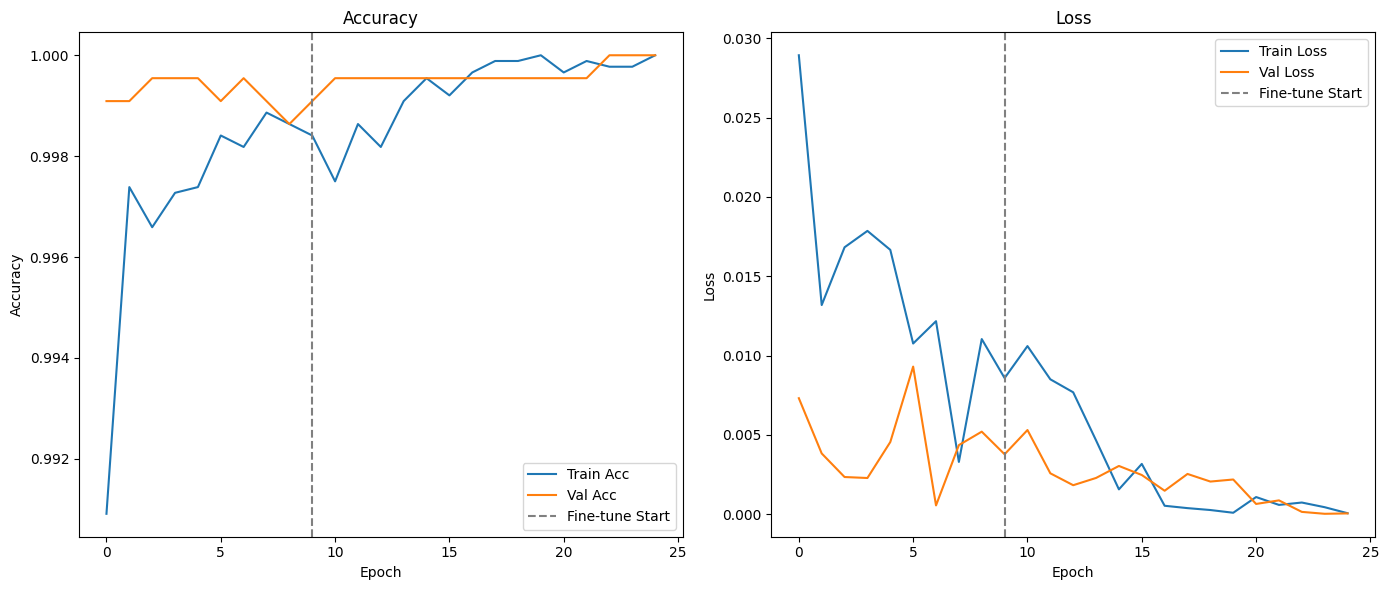

In [15]:
def plot_training_history(history_head, history_finetune=None):
    if not history_head and not history_finetune: print("No training history to plot."); return
    acc, val_acc, loss, val_loss = [], [], [], []
    stage1_epochs = 0
    if history_head and hasattr(history_head, 'history'):
        acc.extend(history_head.history.get('accuracy', []))
        val_acc.extend(history_head.history.get('val_accuracy', []))
        loss.extend(history_head.history.get('loss', []))
        val_loss.extend(history_head.history.get('val_loss', []))
        stage1_epochs = len(history_head.epoch) if hasattr(history_head, 'epoch') else 0
    if history_finetune and hasattr(history_finetune, 'history'):
        acc.extend(history_finetune.history.get('accuracy', []))
        val_acc.extend(history_finetune.history.get('val_accuracy', []))
        loss.extend(history_finetune.history.get('loss', []))
        val_loss.extend(history_finetune.history.get('val_loss', []))
    if not acc: print("No accuracy/loss data found in history objects."); return

    epochs_range = range(len(acc))
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1); plt.plot(epochs_range, acc, label='Train Acc'); plt.plot(epochs_range, val_acc, label='Val Acc')
    if history_finetune and stage1_epochs > 0 and stage1_epochs < len(epochs_range): plt.axvline(x=stage1_epochs -1 , c='gray', ls='--', label='Fine-tune Start')
    plt.legend(loc='lower right'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.subplot(1, 2, 2); plt.plot(epochs_range, loss, label='Train Loss'); plt.plot(epochs_range, val_loss, label='Val Loss')
    if history_finetune and stage1_epochs > 0 and stage1_epochs < len(epochs_range): plt.axvline(x=stage1_epochs -1, c='gray', ls='--', label='Fine-tune Start')
    plt.legend(loc='upper right'); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.tight_layout(); plt.show()

if history_head or history_finetune: plot_training_history(history_head, history_finetune)
else: print("No training occurred, skipping history plot.")

In [16]:
final_model_path_finetuned = os.path.join(MODEL_OUTPUT_DIR, 'resnet50_finetuned_best.h5')
final_model_path_head = os.path.join(MODEL_OUTPUT_DIR, 'resnet50_head_best.h5')
chosen_model_path = None

if os.path.exists(final_model_path_finetuned): chosen_model_path = final_model_path_finetuned
elif os.path.exists(final_model_path_head): chosen_model_path = final_model_path_head
else:
    if model:
        fallback_path = os.path.join(MODEL_OUTPUT_DIR, 'resnet50_manual_save_final.h5')
        try: model.save(fallback_path); chosen_model_path = fallback_path; print(f"Saved current model as fallback: {fallback_path}")
        except Exception as e: print(f"Error saving fallback model: {e}")
            
if chosen_model_path:
    print(f"\nBest available model saved at: {chosen_model_path}")
    try:
        loaded_model = tf.keras.models.load_model(chosen_model_path)
        print("Successfully loaded the chosen model for verification.")
        if len(X_val) > 0 and len(y_val) > 0:
             loss_val, accuracy_val = loaded_model.evaluate(X_val, y_val, verbose=0)
             print(f"Loaded model validation accuracy: {accuracy_val*100:.2f}%")
        else: print("No validation data to evaluate the loaded model.")
    except Exception as e: print(f"Error loading/evaluating model for verification: {e}")
else: print("ERROR: No model was saved during the process.")

print("\n--- Process Complete ---")
print(f"Output models (if any) are in: {MODEL_OUTPUT_DIR}")
print("Download .h5 model from Kaggle 'Output' section after committing.")


Best available model saved at: /kaggle/working/models/resnet50_finetuned_best.h5
Successfully loaded the chosen model for verification.
Loaded model validation accuracy: 100.00%

--- Process Complete ---
Output models (if any) are in: /kaggle/working/models
Download .h5 model from Kaggle 'Output' section after committing.


Loaded model from /kaggle/working/models/resnet50_finetuned_best.h5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,315 (93.98 MB)

 Trainable params: 9,980,929 (38.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 2 (12.00 B)

Loaded and scaled coordinates for camera7 from /kaggle/input/csvfile/data/camera7.csv
   SlotId     X     Y    W    H  X_scaled  Y_scaled  W_scaled  H_scaled
0     611  1240  1596  380  347       478       615       146       133
1     612   292  1552  380  380       112       598       146       146
2     206  1964  1002  340  340       757       386       131       131
3     207  1485  1011  330  330       572       390       127       127
4     208  1088  1016  360  360       419       391       138       138

Analyzing image: c73.jpg
Summary: Occupied: 5, Empty: 41, Total: 46
Saved annotated image to: /kaggle/working/test_results/annotated_c73.jpg


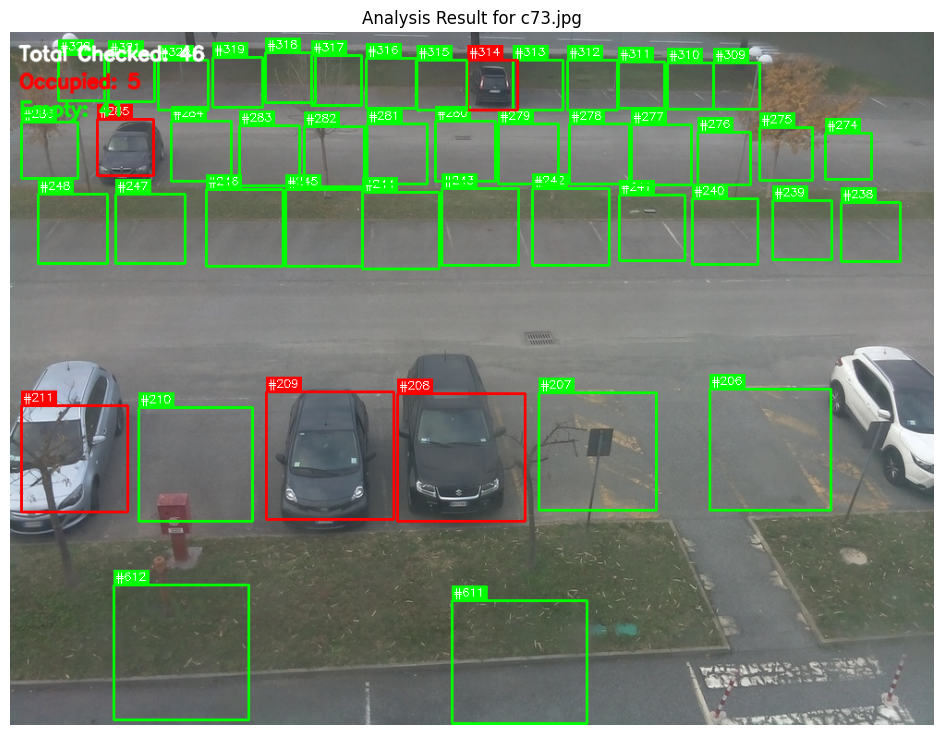

In [19]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
import matplotlib.pyplot as plt

KAGGLE_INPUT_DATASET_NAME = 'my-parking-test-data'

MODEL_PATH = '/kaggle/working/models/resnet50_finetuned_best.h5'
CSV_DATA_PATH = f'/kaggle/input/csvfile/data'
TEST_IMAGES_PATH = f'/kaggle/input/test-samples' # Updated image path
OUTPUT_RESULTS_PATH = '/kaggle/working/test_results/'
os.makedirs(OUTPUT_RESULTS_PATH, exist_ok=True)

IMG_WIDTH_MODEL, IMG_HEIGHT_MODEL = 224, 224

ORIGINAL_IMG_WIDTH_FOR_CSV = 2592
ORIGINAL_IMG_HEIGHT_FOR_CSV = 1944

TEST_IMG_RESOLUTION_W = 1000
TEST_IMG_RESOLUTION_H = 750

SCALE_X = TEST_IMG_RESOLUTION_W / ORIGINAL_IMG_WIDTH_FOR_CSV
SCALE_Y = TEST_IMG_RESOLUTION_H / ORIGINAL_IMG_HEIGHT_FOR_CSV

if not os.path.exists(MODEL_PATH):
    print(f"ERROR: Model file not found at {MODEL_PATH}")
    print("Please ensure the training completed and saved the model, or adjust MODEL_PATH.")
    MODEL_PATH_HEAD = '/kaggle/working/models/resnet50_head_best.h5'
    if os.path.exists(MODEL_PATH_HEAD):
        MODEL_PATH = MODEL_PATH_HEAD
        print(f"Using fallback model: {MODEL_PATH}")
    else:
        MODEL_PATH = None

if MODEL_PATH:
    try:
        model = load_model(MODEL_PATH)
        print(f"Loaded model from {MODEL_PATH}")
        model.summary()
    except Exception as e:
        print(f"Error loading model: {e}")
        model = None
else:
    model = None
    print("No model path specified or model not found.")


camera_id_to_test = 'camera7' # Updated camera ID for CSV
csv_file_path = os.path.join(CSV_DATA_PATH, f'{camera_id_to_test}.csv')

if not os.path.exists(csv_file_path):
    print(f"ERROR: CSV file not found at {csv_file_path}")
    parking_spaces_df = None
else:
    parking_spaces_df = pd.read_csv(csv_file_path)
    parking_spaces_df['X_scaled'] = (parking_spaces_df['X'] * SCALE_X).astype(int)
    parking_spaces_df['Y_scaled'] = (parking_spaces_df['Y'] * SCALE_Y).astype(int)
    parking_spaces_df['W_scaled'] = (parking_spaces_df['W'] * SCALE_X).astype(int)
    parking_spaces_df['H_scaled'] = (parking_spaces_df['H'] * SCALE_Y).astype(int)
    print(f"Loaded and scaled coordinates for {camera_id_to_test} from {csv_file_path}")
    print(parking_spaces_df.head())

def analyze_image_with_model(full_image_path, spaces_df, trained_model):
    if trained_model is None:
        print("Model not loaded. Skipping analysis.")
        return None
    if spaces_df is None:
        print("Parking spaces DataFrame not loaded. Skipping analysis.")
        return None
    if not os.path.exists(full_image_path):
        print(f"Test image not found: {full_image_path}")
        return None

    img_bgr = cv2.imread(full_image_path)
    if img_bgr is None:
        print(f"Could not read test image: {full_image_path}")
        return None
    
    if img_bgr.shape[1] != TEST_IMG_RESOLUTION_W or img_bgr.shape[0] != TEST_IMG_RESOLUTION_H:
        print(f"Warning: Test image {os.path.basename(full_image_path)} resolution ({img_bgr.shape[1]}x{img_bgr.shape[0]}) "
              f"differs from assumed TEST_IMG_RESOLUTION ({TEST_IMG_RESOLUTION_W}x{TEST_IMG_RESOLUTION_H}). "
              "Coordinate scaling might be inaccurate.")


    img_display = img_bgr.copy()
    occupied_count = 0
    empty_count = 0

    print(f"\nAnalyzing image: {os.path.basename(full_image_path)}")

    patches_for_batch_prediction = []
    coords_for_batch = []

    for _, row in spaces_df.iterrows():
        x, y, w, h = row['X_scaled'], row['Y_scaled'], row['W_scaled'], row['H_scaled']
        slot_id = row['SlotId']

        img_h_actual, img_w_actual = img_bgr.shape[:2]
        x = max(0, x); y = max(0, y)
        if x + w > img_w_actual: w = img_w_actual - x
        if y + h > img_h_actual: h = img_h_actual - y
        
        if w <= 0 or h <= 0:
            continue

        patch_bgr = img_bgr[y:y+h, x:x+w]
        if patch_bgr.size == 0:
            continue
        
        patch_resized = cv2.resize(patch_bgr, (IMG_WIDTH_MODEL, IMG_HEIGHT_MODEL))
        patch_processed = resnet_preprocess_input(patch_resized.astype('float32'))
        patches_for_batch_prediction.append(patch_processed)
        coords_for_batch.append({'x':x, 'y':y, 'w':w, 'h':h, 'id':slot_id})

    if not patches_for_batch_prediction:
        print("No valid patches extracted from the image.")
        return img_display

    batch_patches_np = np.array(patches_for_batch_prediction)
    predictions = trained_model.predict(batch_patches_np, verbose=0)

    for i, pred_value in enumerate(predictions):
        is_occupied = pred_value[0] > 0.5
        space_info = coords_for_batch[i]
        x, y, w, h, slot_id = space_info['x'], space_info['y'], space_info['w'], space_info['h'], space_info['id']

        if is_occupied:
            color = (0, 0, 255)
            status_text = "OCC"
            occupied_count += 1
        else:
            color = (0, 255, 0)
            status_text = "EMP"
            empty_count += 1
        
        cv2.rectangle(img_display, (x, y), (x + w, y + h), color, 2)
        
        text = f"#{slot_id}"
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        cv2.rectangle(img_display, (x, y - text_height - 7), (x + text_width + 4, y -2) , color, -1)
        cv2.putText(img_display, text, (x + 2, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)

    total_slots = occupied_count + empty_count
    summary_text_occupied = f"Occupied: {occupied_count}"
    summary_text_empty = f"Empty: {empty_count}"
    summary_text_total = f"Total Checked: {total_slots}"

    cv2.putText(img_display, summary_text_total, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img_display, summary_text_occupied, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img_display, summary_text_empty, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
    
    print(f"Summary: Occupied: {occupied_count}, Empty: {empty_count}, Total: {total_slots}")
    return img_display

test_image_files = ['c73.jpg'] # Updated test image file

if model and parking_spaces_df is not None:
    for img_filename in test_image_files:
        full_img_path = os.path.join(TEST_IMAGES_PATH, img_filename)
        
        annotated_image = analyze_image_with_model(full_img_path, parking_spaces_df, model)
        
        if annotated_image is not None:
            output_filename = os.path.join(OUTPUT_RESULTS_PATH, f"annotated_{img_filename}")
            cv2.imwrite(output_filename, annotated_image)
            print(f"Saved annotated image to: {output_filename}")

            plt.figure(figsize=(12, 9))
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Analysis Result for {img_filename}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Could not generate annotated image for {img_filename}")
elif model is None:
    print("Model was not loaded. Cannot run tests.")
elif parking_spaces_df is None:
    print("Parking space coordinate data (CSV) was not loaded. Cannot run tests.")